In [2]:
import pandas as pd
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os.path as checkPath

In [3]:
def loadData(year_filt, filter_functions):
    pxp = []
    #distance: yards to go
    #yardLine: standardized to the 100 --> goal end zone 0
    #type: playtype
    cols = ['offenseAbbr', 'down', 'yardLine', 'distance', 'type', 'FieldGoalResult']
    # 2001 to 2017
    year_start_data = 2001
    year_end_data = 2018
    if year_filt is not None:
        year_start_data, year_end_data = year_filt()
    for year in range(year_start_data, year_end_data):
        for weekNum in range(1, 16):
            week = 'Week ' + str(weekNum)
            file = 'Improved-NCAA-Football-Data/{0}PXP/PBP - {0} - '.format(year) + week + '.csv'
            if (checkPath.isfile(file)):
                plays = pd.read_csv(file, usecols=cols)
                pxp.append(plays)

    pxp = pd.concat(pxp)
    pxp = pxp.loc[(pxp['down'] == 4) & (pxp['type'] != 'No Play') & (pxp['type'] != 'Fumble Recovery (Opponent)') & (pxp['type'] != 'Timeout') & (pxp['type'] != '')]
    pxp['down'] = pxp['down'].apply(lambda down: int(down))
    pxp['yardLine'] = pxp['yardLine'].apply(lambda yd: int(yd))
    pxp['distance'] = pxp['distance'].apply(lambda yd: int(yd))
    pxp['offenseAbbr'] = pxp['offenseAbbr'].apply(lambda team: str(team))
    pxp['FieldGoalResult'] = pxp['FieldGoalResult'].apply(lambda result: int(result == 'Made'))
    return pxp

In [4]:
def getTeamMapping(year_filt, filter_functions, condensed=True):
    pxp = loadData(year_filt, filter_functions)
    mapping = {}
    for index, row in pxp.iterrows():
        posteam = row['offenseAbbr']
        yrdline100 = row['yardLine']
        ydstogo = row['distance']
        playtype = row['type']
        if condensed:
            #ALL SACKS ARE CLASSIFIED AS 'GO FOR IT'
            if playtype != 'Field Goal' and playtype != 'Punt':
                playtype = 'Go For It'       
        if posteam in mapping:
            yrdline100dict = mapping[posteam]
            if yrdline100 in yrdline100dict:
                ydstogomapping = yrdline100dict[yrdline100]
                if ydstogo in ydstogomapping:
                    playtypefreq = ydstogomapping[ydstogo]
                    if playtype in playtypefreq:
                        playtypefreq[playtype] += 1
                    else:
                        playtypefreq[playtype] = 1
                else:
                    ydstogomapping[ydstogo] = {}
                    playtypefreq = ydstogomapping[ydstogo]
                    playtypefreq[playtype] = 1
            else:
                yrdline100dict[yrdline100] = {}
                ydstogomapping = yrdline100dict[yrdline100]
                ydstogomapping[ydstogo] = {}
                playtypefreq = ydstogomapping[ydstogo]
                playtypefreq[playtype] = 1
        else:
            mapping[posteam] = {}
            yrdline100dict = mapping[posteam]
            yrdline100dict[yrdline100] = {}
            ydstogomapping = yrdline100dict[yrdline100]
            ydstogomapping[ydstogo] = {}
            playtypefreq = ydstogomapping[ydstogo]
            playtypefreq[playtype] = 1
    if filter_functions is not None:
        for filterf in filter_functions:
            mapping = filterf(mapping)
    return mapping

In [5]:
def getTeamMappingwFGResult(year_filt, filter_functions):
    pxp = loadData(year_filt, filter_functions)
    mapping = {}
    negmapping = {}
    fg_attempts = [0 for x in range(0, 100)]
    for index, row in pxp.iterrows():
        posteam = row['offenseAbbr']
        yrdline100 = row['yardLine']
        ydstogo = row['distance']
        playtype = row['type']
        fgresult = row['FieldGoalResult']    
        if yrdline100 > 0 and yrdline100 <= 100:
            if posteam in mapping:
                yrdline100dict = mapping[posteam]
                if yrdline100 in yrdline100dict:
                    ydstogomapping = yrdline100dict[yrdline100]
                    if ydstogo in ydstogomapping:
                        ydstogomapping[ydstogo] += fgresult
                        fg_attempts[yrdline100 - 1] += 1
                    else:
                        ydstogomapping[ydstogo] = fgresult
                        fg_attempts[yrdline100 - 1] += 1
                else:
                    yrdline100dict[yrdline100] = {}
                    ydstogomapping = yrdline100dict[yrdline100]
                    ydstogomapping[ydstogo] = fgresult
                    fg_attempts[yrdline100 - 1] += 1
            else:
                mapping[posteam] = {}
                yrdline100dict = mapping[posteam]
                yrdline100dict[yrdline100] = {}
                ydstogomapping = yrdline100dict[yrdline100]
                ydstogomapping[ydstogo] = fgresult
                fg_attempts[yrdline100 - 1] += 1

            if posteam in negmapping:
                yrdline100dict = negmapping[posteam]
                if yrdline100 in yrdline100dict:
                    ydstogomapping = yrdline100dict[yrdline100]
                    if ydstogo in ydstogomapping:
                        ydstogomapping[ydstogo] += (fgresult - 1)
                    else:
                        ydstogomapping[ydstogo] = fgresult - 1
                else:
                    yrdline100dict[yrdline100] = {}
                    ydstogomapping = yrdline100dict[yrdline100]
                    ydstogomapping[ydstogo] = fgresult - 1
            else:
                negmapping[posteam] = {}
                yrdline100dict = negmapping[posteam]
                yrdline100dict[yrdline100] = {}
                ydstogomapping = yrdline100dict[yrdline100]
                ydstogomapping[ydstogo] = fgresult - 1
            
    if filter_functions is not None:
        for filterf in filter_functions:
            mapping = filterf(mapping)
    return mapping, negmapping, fg_attempts

In [6]:
mapping = {}
neg_mapping = {}
fg_attempts = []

In [7]:
def playteamfrequency(team, yrdLine, ydstogo):
    #trying to make this global so it doesn't have to undergo this function call every time this method used.
    #(used in a loop)
    #mapping = getTeamMapping(year_filt, filter_functions)
    if yrdLine <= 0 or yrdLine >= 100:
        raise ValueError('Invalid yard line')
    if team not in mapping:
        raise ValueError('No such team ' + team + ' in the given data.')
    if yrdLine not in mapping[team]:
        raise ValueError('No such YrdLine found for ' + team + ' in the data.')
    if ydstogo not in mapping[team][yrdLine]:
        raise ValueError('No plays 4th and ' + str(ydstogo) + ' at the ' + str(yrdLine) + ' yard line')
    
    playfrequencies = mapping[team][yrdLine][ydstogo]
    playTypes = ['Go For It', 'Punt', 'Field Goal']
    frequency = []

    if 'Go For It' in playfrequencies:
        frequency.append(playfrequencies['Go For It'])
    else:
        frequency.append(0)
            
    if 'Punt' in playfrequencies:
        frequency.append(playfrequencies['Punt'])
    else:
        frequency.append(0)
        
    if 'Field Goal' in playfrequencies:
        frequency.append(playfrequencies['Field Goal'])
    else:
        frequency.append(0)


    #plt.bar(playTypes, frequency)
    #plt.xlabel('Play Type')
    #plt.ylabel('Frequency')
    #plt.title('Team: ' + team + ' at 4th and ' + str(ydstogo) + ' at the ' + str(yrdLine) + ' yard line')
    
    #plt.show()
            
    return frequency

In [8]:
def getBiggestPlay(team, yrdLine, yrdstogo): 
    countPlays = playteamfrequency(team, yrdLine, yrdstogo)
    
    max = countPlays[0]
    maxIndex = 0
    for i in range(1, len(countPlays)):
        if countPlays[i] > max:
            max = countPlays[i]
            maxIndex = i
    if maxIndex == 0:
        return 'Go For It', max
    elif maxIndex == 1:
        return 'Punt', max
    elif maxIndex == 2:
        return 'Field Goal', max

In [9]:
def getmostcommonplaybyteam(team):
    teamdict = mapping[team]
    
    
    #most common is a 2D dictionary in which is organized by yrdline and yrds to go.
    #it stores 1 of 3 possible strings which shows the most common play on 4th down
    most_common = {}
    
    #number of most common plays is also a 2D dictionary in which is organized by yrdline and yrds to go.
    #At yrd Line L, and yrds to go G, it stores the number of times play most_common[L][G] was made.
    number_of_most_common_plays = {}
    
    for i in range(1, 100):
        if i in teamdict:
            yrdline100dict = teamdict[i]
            most_common[i] = {}
            number_of_most_common_plays[i] = {}
            for j in range(1, 10):
                if j in yrdline100dict:
                    most_common_play, number_of_plays = getBiggestPlay(team, i, j)
                    most_common[i][j] = most_common_play
                    number_of_most_common_plays[i][j] = number_of_plays
    
    
    return pd.DataFrame(most_common), most_common, number_of_most_common_plays

In [10]:

#df

In [11]:
cmap = plt.cm.magma


In [12]:
def mostCommonMap(team):
    df, mostcommon, num_most_common = getmostcommonplaybyteam(team)
    data = np.zeros((9, 99))
    val = 0
    for i in range(1, 10):
        for j in range(1, 100):
            if j not in mostcommon:
                val = np.nan
            else:
                if i in mostcommon[j]:
                    decision = mostcommon[j][i]
                    if decision == 'Punt':
                        val = 0
                    elif decision == 'Go For It':
                        val = 5
                    elif decision == 'Field Goal':
                        val = 10
                else:
                    val = np.nan
            data[i - 1, j - 1] = val


    data = data[::-1,::-1]

    fig, ax = plt.subplots(figsize=(12, 9))

    ax.pcolor(
        data,
        vmin = 1,
        vmax = 15,
        edgecolors='k', 
        linewidths=.2,
        cmap=cmap,
        alpha=.6
    );
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ax.set_xticklabels(['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
    ax.set_yticks([yd - .5 for yd in range(1, 10)])
    ax.set_yticklabels(['4th and {}'.format(yd) for yd in range(9, 0, -1)])
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

In [13]:
def printHeatMap(team):
    playfrequencies = {}
    data = np.zeros((9, 99))
    if team not in mapping:
        raise ValueError('No such team ' + team + ' in the given data with set constraints.')
    for i in range(1, 10):
        for j in range(1, 100):
            if j in mapping[team]:
                if i in mapping[team][j]:
                    playfrequencies[j] = {}
                    playfrequencies[j][i] = playteamfrequency(team, j, i)
                    freq = playfrequencies[j][i]
                    goforit = freq[0]
                    punt = freq[1]
                    fieldgoal = freq[2]
                    total = goforit + punt + fieldgoal
                    goforit = goforit / total
                    punt = punt / total
                    fieldgoal = fieldgoal / total
                    val = 5 + punt * -5 + fieldgoal * 5
                else:
                    val = np.nan
            else:
                val = np.nan
            data[i - 1, j - 1] = val
    data = data[::-1,::-1]

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    ax.pcolor(data, edgecolors='k', linewidths=.2, cmap=cmap, alpha=.6)
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ax.set_xticklabels(['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
    ax.set_yticks([yd - .5 for yd in range(1, 10)])
    ax.set_yticklabels(['4th and {}'.format(yd) for yd in range(9, 0, -1)])
    ax.tick_params(axis='both', which='major', labelsize=15)

    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=[0, 0.5, 1])
    cb.ax.set_yticklabels(['Punt', 'Go For It', 'Field Goal']) 

    plt.show()

In [14]:
############################################################################################################

################ MUST BE CALLED BEFORE OTHER FUNCTION CALLS IF WANTING TO FILTER DATA. #####################

############################################################################################################

def filterMap(year_filt, filter_functions, FGResultWanted):
    fg_attempts = None
    if not FGResultWanted:
        global mapping
        mapping = getTeamMapping(year_filt, filter_functions)
    else:
        global neg_mapping
        mapping, neg_mapping, fg_attempts = getTeamMappingwFGResult(year_filt, filter_functions)
    if fg_attempts is not None:
        return fg_attempts

In [15]:
def anderson_year_filter():
    return 2015, 2018

In [16]:
filterMap(None, None, False)

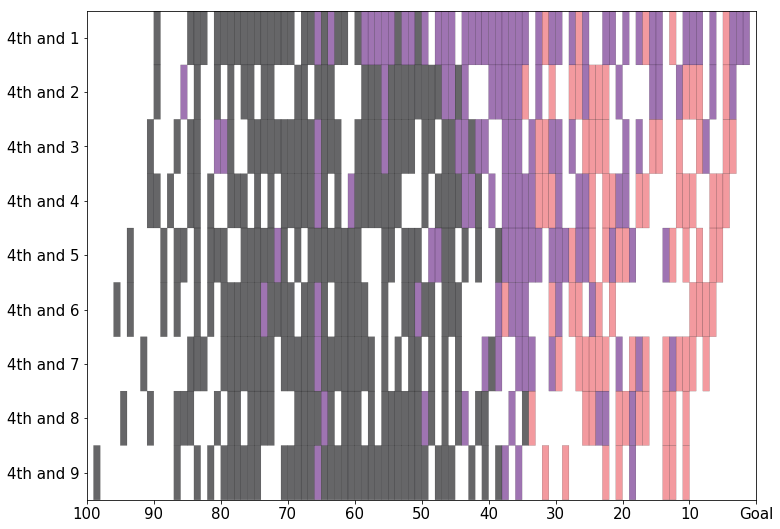

In [17]:
mostCommonMap('CAL')

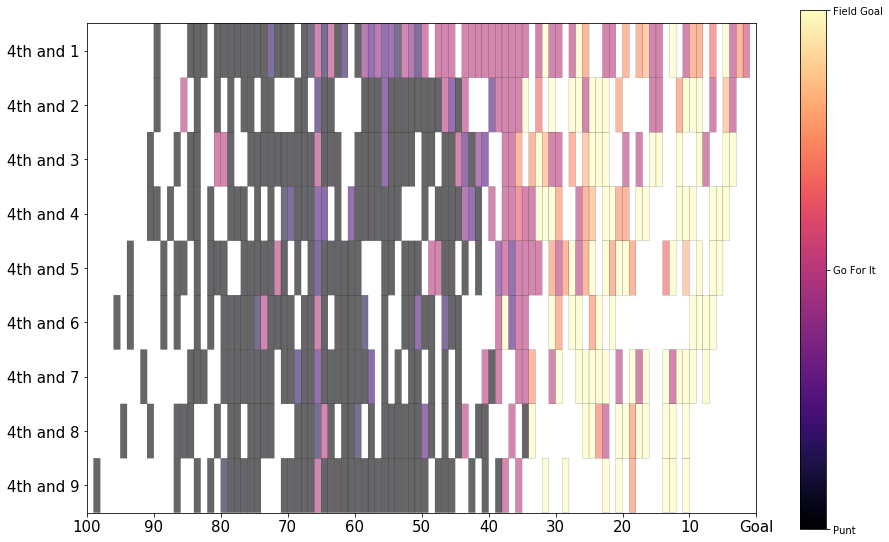

In [18]:
printHeatMap('CAL')

In [51]:
def printHeatMap_10yd_increments(team):
    playfrequencies = {}
    data = np.zeros((9, 99))
    if team not in mapping:
        raise ValueError('No such team ' + team + ' in the given data with set constraints.')
    for i in range(1, 10):
        for j in range(1, 100):
            if j in mapping[team]:
                if i in mapping[team][j]:
                    playfrequencies[j] = {}
                    playfrequencies[j][i] = playteamfrequency(team, j, i)
                    freq = playfrequencies[j][i]
                    goforit = freq[0]
                    punt = freq[1]
                    fieldgoal = freq[2]
                    total = goforit + punt + fieldgoal
                else:
                    val = np.nan
            else:
                val = np.nan
            if (j % 10 == 0):
                goforit = goforit / total
                punt = punt / total
                fieldgoal = fieldgoal / total
                val = 5 + punt * -5 + fieldgoal * 5
                test = (int) (j / 10 - 1)
                for t in range(j - 10, j):
                    data[i - 1, t] = val
    data = data[::-1,::-1]

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    ax.pcolor(data, edgecolors='k', linewidths=0, cmap=cmap, alpha=0.6)
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ax.set_xticklabels(['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
    ax.set_yticks([yd - .5 for yd in range(1, 10)])
    ax.set_yticklabels(['4th and {}'.format(yd) for yd in range(9, 0, -1)])
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=[0, 5, 10])
    cb.ax.set_yticklabels(['Punt', 'Go For It', 'Field Goal']) 

    plt.show()

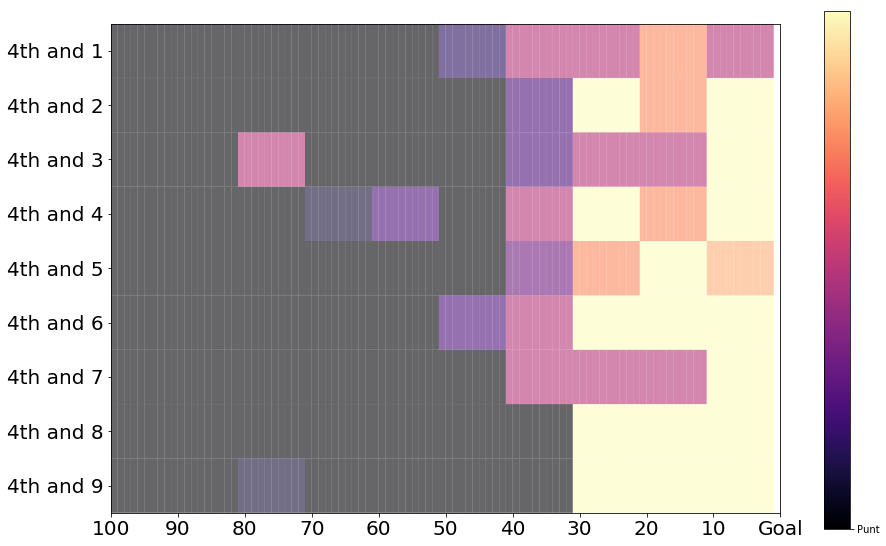

In [52]:
printHeatMap_10yd_increments('CAL')

In [ ]:
PAC_12 = ['USC', ]

In [236]:
fg_attempts = filterMap(anderson_year_filter, None, True)

In [257]:
def exportAndersonData(team):
    global fg_attempts
    df = {}
    yrd_line_made = [None] * 50
    attempt_corresponding = [0] * 50
    index_made = 0
    for yrdline100 in mapping[team]:
        num_made_fg = 0
        for ydstogo in mapping[team][yrdline100]:
            num_made_fg += mapping[team][yrdline100][ydstogo]
        if num_made_fg > 0:
            yrd_line_made[index_made] = yrdline100
            attempt_corresponding[index_made] = fg_attempts[yrdline100]
            index_made += 1
            
    yrd_line_missed = [None] * 100
    attempt_corresponding_missed = [0] * 100
    index_missed = 0
    for yrdline100 in neg_mapping[team]:
        num_missed_fg = 0
        for ydstogo in neg_mapping[team][yrdline100]:
            num_missed_fg += neg_mapping[team][yrdline100][ydstogo]
        if num_missed_fg < 0:
            yrd_line_missed[index_missed] = yrdline100
            attempt_corresponding_missed[index_missed] = fg_attempts[yrdline100]
            index_missed += 1
    
    new_made_yrdline = [yrd_line_made[i] for i in range(0, 50) if yrd_line_made[i] is not None]
    corr_attempts_made = [attempt_corresponding[i] for i in range(0, 50) if yrd_line_made[i] is not None]
    new_missed_yrdline = [yrd_line_missed[i] for i in range(0, 50) if yrd_line_missed[i] is not None]
    corr_attempts_missed = [attempt_corresponding_missed[i] for i in range(0, 50) if yrd_line_missed[i] is not None]
    
    #The following is extremely messy- used to fix a bug. Will clean up later.
    df['FG Made (Yard Line)'] = new_made_yrdline
    df2 = {}
    df2['Attempts'] = corr_attempts_made
    df3 = {}
    df3['FG Missed (Yard Line)'] = new_missed_yrdline
    df4 = {}
    df4['Attempts From This YD Line'] = corr_attempts_missed
    
    
    df = pd.DataFrame(df)
    df2 = pd.DataFrame(df2)
    df3 = pd.DataFrame(df3)
    df4 = pd.DataFrame(df4)
    #writer = pd.ExcelWriter('Anderson-Data.xlsx', engine='xlsxwriter')
    #df.to_excel(writer, sheet_name='Sheet1')
    #writer.save()
    
    df.to_csv("FG MADE MATT ANDERSON.csv")
    df2.to_csv("FG ATTEMPTS-CORRESPONDING TO MADE- MATT ANDERSON.csv")
    df3.to_csv("FG MISSED MATT ANDERSON.csv")
    df4.to_csv("FG ATTEMPTS-CORRESPONDING TO MISS- MATT ANDERSON.csv")

In [258]:
exportAndersonData('CAL')